In [2]:
import numpy as np
from loadMNIST import LoadMNIST
import matplotlib.pyplot as plt
%matplotlib inline

## An optimal linear classifier for multiple classes
In this notebook, we'll build a classifer to discriminate between all of the digits in the MNIST database.

Instead of sticking to a 2D feature space that allows us to hand-code an excellent classifier, we'll use a $D \geq K$ feature space, where $D$ is the dimension of the feature space and $K=10$ is the number of class labels.

This notebook will follow the same outline as the DIY classifier notebook

### The data
We'll use the MNIST dataset for this exercise. First we'll load up the images and normalize them.

In [3]:
##load all MNIST images

mnist_trn_img = '/mnt/fast/MNIST/train-images-idx3-ubyte'
mnist_trn_lab = '/mnt/fast/MNIST/train-labels-idx1-ubyte'
mnist_val_img = '/mnt/fast/MNIST/t10k-images-idx3-ubyte'
mnist_val_lab = '/mnt/fast/MNIST/t10k-labels-idx1-ubyte'

mnist_trn_data = LoadMNIST(mnist_trn_img).astype('float32')
mnist_val_data = LoadMNIST(mnist_val_img).astype('float32')
mnist_trn_label = LoadMNIST(mnist_trn_lab)
mnist_val_label = LoadMNIST(mnist_val_lab)

K = 10 ##number of classes
n_trn_images = mnist_trn_data.shape[0]
n_val_images = mnist_val_data.shape[0]
pixel_res = mnist_trn_data.shape[1]

print 'there are %d images in the training set' %(n_trn_images)
print 'there are %d images in the validation set' %(n_val_images)

##these will be useful later on
trn_img_idx = np.arange(n_trn_images).astype('int')
val_img_idx = np.arange(n_val_images).astype('int')

>u1
(60000, 28, 28)
>u1
(10000, 28, 28)
>u1
(60000,)
>u1
(10000,)
there are 60000 images in the training set
there are 10000 images in the validation set


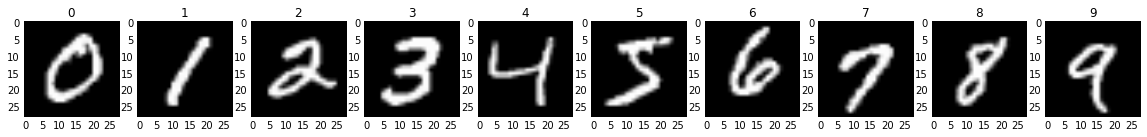

In [4]:
##sanity check
fig = plt.figure(figsize=(20,20))

for k in range(K):
    plt.subplot(1,K,k+1)
    idx = trn_img_idx[mnist_trn_label==k][0]
    plt.imshow(mnist_trn_data[idx],cmap='gray')
    plt.title('%d' %(k))




It is generally a good idea to normalize the input data, so that feature space is not dominated by the "brightness" of images, but rather by their shape. To do this, we first subtract the mean from each image, then divide each image by it's magnitude

In [5]:
##normalize images so that each 
##note the use of np.newaxis to take advantage of broadcasting rules!
for arr in [mnist_trn_data, mnist_val_data]:
    arr -= np.mean(arr,axis=(1,2))[:,np.newaxis,np.newaxis]  
    arr /= np.sqrt(np.sum(arr**2,axis=(1,2)))[:,np.newaxis,np.newaxis]

In [6]:
np.mean(mnist_trn_data,axis=(1,2))

array([  0.00000000e+00,   3.04105324e-10,   0.00000000e+00, ...,
         7.60263352e-10,   6.08210649e-10,   4.56158000e-10], dtype=float32)

### The feature space
We'll construct a simple linear transform that maps each MNIST image into a point in a K-dimensional feature space.

The axes of this feature space will correspond to randomly selected examples of each digit.

Select two images from the training data to be "templates"

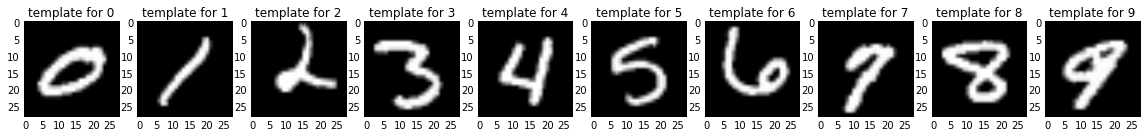

In [7]:
temp_idx = np.zeros(K).astype('int')
templates = np.zeros((K,pixel_res,pixel_res))
for k in range(K):
    temp_idx[k] = np.random.permutation(trn_img_idx[mnist_trn_label==k])[0]
    templates[k] = mnist_trn_data[temp_idx[k]]

fig = plt.figure(figsize=(20,20))
##view your templates
for k in range(K):
    plt.subplot(1,K,k+1)
    plt.imshow(templates[k],cmap='gray')
    plt.title('template for %d' %(k))


Let $\mathbf{t}_i$ be the template for digit $i$. Let $\mathbf{s}$ be an image in the training set. Map all training data images into $D=K$-dimensional feature space defined

$\phi(\mathbf{s}) = (\mathbf{s} \cdot \mathbf{t_0}, \ldots , \mathbf{s} \cdot \mathbf{t_K})$

In [8]:
##first, we reshape the templates and stack them into a matrix
templates = templates.reshape((K,pixel_res**2)).T
print templates.shape

# ##next we project each of the images onto the templates
##in what follows, we'll want samples along the columns, and feature dimensions along the rows.
##so we'll take a transpose here
trn_features = mnist_trn_data.reshape((n_trn_images,pixel_res**2)).dot(templates).T
print trn_features.shape

val_features = mnist_val_data.reshape((n_val_images,pixel_res**2)).dot(templates).T
print val_features.shape


(784, 10)
(10, 60000)
(10, 10000)


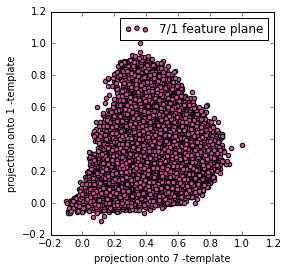

In [9]:
##for sanity, view the projections of into the 2D plane defined by the i^th and j^th templates
one_color = np.array([.8,.3,.6])  ##pinkish
i_temp = 7
j_temp = 1

plt.scatter(trn_features[i_temp,:], trn_features[j_temp,:],c=one_color,label='%d/%d feature plane' %(i_temp,j_temp), alpha = 1)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('projection onto %d -template' %(i_temp))
plt.ylabel('projection onto %d -template' %(j_temp))

Different projections have different 2D distributions. Some pairs of templates seem to pull the data points apart; some seem to smoosh them together.

### Building an optimal multi-class classifier

Previously we discussed a the multi-class discriminant function:

$\mathbf{y}(\mathbf{x}) = W\mathbf{x}$,

where the $K \times D$ weight matrix $W$ is defined:

$W = \begin{bmatrix} -&\mathbf{w}^T_1&-\\ \quad&\ldots&\quad \\ -&\mathbf{w}^T_K&- \end{bmatrix}$

and $\mathbf{w}^T_k = \left (b_k, w_{k1}, \ldots, w_{k,D-1} \right ) $

and $\mathbf{x} = \begin{bmatrix} 1\\x_1\\ \vdots\\ x_{D-1} \end{bmatrix}$

Then the class label $c_i$ for a single data point $\mathbf{x}_i$ is just:

$c_i = \operatorname{argmax} \mathbf{y}(\mathbf{x}_i)$

Note that in our feature space notation, $\mathbf{x}_i = \phi(\mathbf{s}_i)$.

Our goal will be to find the optimal weight matrix $W^*$. We'll define "optimal" as the weight matrix that minimizes sum of distances between the discriminator output $\mathbf{y}(\mathbf{x}_i)$ and a corresponding target vector $\mathbf{t}_i$ that encodes the $K$ clases as a $K$-bit binary string. So for example, if $K=4$ and $c_i=3$ then

$\mathbf{t}_i = \begin{bmatrix} 0\\0\\1\\0  \end{bmatrix}$

Assuming we have $N$ data samples, the sum of squared distances cost function is then

$
\begin{equation}
\begin{split}
 L(W) = & \sum_{i=1}^{i=N}\left | \left | \mathbf{y}(\mathbf{x}_i) - \mathbf{t}_i \right | \right |^2 \\
      = & \sum_{i=1}^{i=N}\left | \left | W\mathbf{x}_i - \mathbf{t}_i \right | \right |^2 
 \end{split}
 \end{equation}
$

and 

$W^* = \operatorname{argmin} L(W)$

As we discussed in class, we'll estimate $W^*$ by making an initial guess about it's value, and then performing gradient descent on the cost function until we reach the (a) minumum:

$W_{t+1} = W_t - \Delta \frac{dL(W)}{dW}$

where $\Delta$ is the (scalar) step size. In this case, the gradient has a simple expression:

$\frac{dL(W)}{dW} = \sum_{i=1}^{i=N}2\left (W\mathbf{x}_i - \mathbf{t}_i \right )\mathbf{x}_i^T$

We can sanity-check the expression of the gradient by making sure it that dimensions of $W$ (which is a $K \times D$ matrix). To do this we write out the shape of each term in the expression and get

$\left ( \left (K \times D \right ) \left (D \times 1 \right ) - \left (K \times 1 \right ) \right) \left ( 1 \times D \right ) = \left (K \times 1 \right ) \left ( 1 \times D \right) = \left (K \times D \right ) $

Now we'll write a multi-class discriminant function, a function to compute $L(W)$, and a gradient function. Then we'll iterate out the equation above until some time-step $t^*$ such that $L(W_{t^*}) - L(W_{t^*-1})$ is below some threshold; i.e., we'll stop when the cost stops decreasing.


In [10]:
##a basically gutless discriminant function
def discriminant_function(X,W):
    '''
    discriminant_function(X,W)
    X = D x N matrix of D x 1 of data columns. Note: We assume the top row of "X" is all 1's !!
    W = K x D weight matrix
    returns y(x) = Wx which has dimensions K x N
    '''
    return W.dot(X)

In [11]:
def cost_function(T, X,W):
    '''
    cost_function(T,X,W)
    T ~ K x N matrix of class labels
    X ~ D x N matrix of D x 1 data columns
    W ~ K x D weight matrix
    returns sum of squared lengths of the difference vectors Wx-t
    '''
    diff = discriminant_function(X,W) - T ##K x N
    return np.sum(np.sum(diff**2,axis=0)) 

In [12]:
def gradient(T, X, W):
    '''
    T ~ K x N matrix of class labels
    X ~ D x N matrix of D x 1 data columns
    W ~ K x D weight matrix
    returns the K x D gradient of cost_function with respect to W
    '''
    diff = discriminant_function(X,W) - T  ##K x N
    return diff.dot(X.T)  ##(K x N) (N x D)


In [13]:
def performance(T,X,W):
    N = T.shape[1]
    trial_dx = range(N)
    y = discriminant_function(X,W)
    class_labels = np.argmax(y,axis=0)
    num_correct = np.sum(T[list(class_labels),trial_dx])
    prc_correct = num_correct/float(N)
    print 'percent correct: %0.2f' %(prc_correct)
    return prc_correct

### Gradient descent loop
Now we implement a gradient descent loop on the template-based feature representation we established above.

We must first format the input/output data to align with the equations above. This means adding "1's" to the input data, and formatting the class labels in the $1-$of$-K$ format we describe above.

In [14]:
##encode the dimensions of the problem using the notation we've developed above
D = K+1 ##the +1 accounts for the bias term
N_trn = n_trn_images
N_val = n_val_images

##prepare the feature data by adding appending a 1 to each of the data samples
X_trn = np.concatenate([np.ones((1,N_trn)),trn_features])
print X_trn.shape
X_val = np.concatenate([np.ones((1,N_val)),val_features])
print X_val.shape

##prepare the target data (the class labels)
##Note: we convert the indices from arrays to lists to bypass numpy's broadcasting rules, which can complicate
##integer-based indexing.
T_trn = np.zeros((K,N_trn))
T_trn[list(mnist_trn_label),list(trn_img_idx)] = 1
##sanity check the training data
print T_trn[:,10], mnist_trn_label[10]

T_val = np.zeros((K,N_val))
T_val[list(mnist_val_label),list(val_img_idx)] = 1
##sanity check the validation data
print T_val[:,10], mnist_val_label[10]


(11, 60000)
(11, 10000)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.] 3
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] 0


Here we implement the actual training loop

In [15]:
##random starting point
W_new = np.random.randn(K,D)

##calculate initial performance
print 'Starting performance'
P_new = performance(T_trn,X_trn,W_new)
print 'chance is: %0.2f' %(1./K)

##step-size
delta = 0.01

##stopping criterion: stop when difference between successive costs less than this number
l_stop = 10e-4

##also, to keep from running forever, we put in a back stop
max_iters = 10000

##step size
delta = 0.00001

##we'll want output during training, but probably not on every step
report_every = 100

##calculate initial cost
L_old = np.inf  ##this is a trick. "inf - x" is never less than anything. 
L_new = cost_function(T_trn,X_trn,W_new)
print 'cost: %0.3f' %(L_new)


##train that model!
iteration = 0
while (iteration <= max_iters) & ((L_old - L_new) > l_stop):
    W_grad = gradient(T_trn,X_trn,W_new)
    W_new -= W_grad*delta
    L_old = np.copy(L_new)
    L_new = cost_function(T_trn,X_trn,W_new)
    if not np.mod(iteration,report_every):
        print 'iteration: %d, cost: %0.3f' %(iteration,L_new)
    iteration += 1

##calculate initial performance
print 'Final performance'
P_new = performance(T_trn,X_trn,W_new)

Starting performance
percent correct: 0.10
chance is: 0.10
cost: 1075389.080
iteration: 0, cost: 131260.611
iteration: 100, cost: 51425.933
iteration: 200, cost: 44904.442
iteration: 300, cost: 42493.245
iteration: 400, cost: 41235.126
iteration: 500, cost: 40480.055
iteration: 600, cost: 39988.689
iteration: 700, cost: 39650.258
iteration: 800, cost: 39407.102
iteration: 900, cost: 39226.754
iteration: 1000, cost: 39089.732
iteration: 1100, cost: 38983.695
iteration: 1200, cost: 38900.451
iteration: 1300, cost: 38834.350
iteration: 1400, cost: 38781.371
iteration: 1500, cost: 38738.581
iteration: 1600, cost: 38703.792
iteration: 1700, cost: 38675.349
iteration: 1800, cost: 38651.981
iteration: 1900, cost: 38632.699
iteration: 2000, cost: 38616.729
iteration: 2100, cost: 38603.458
iteration: 2200, cost: 38592.396
iteration: 2300, cost: 38583.152
iteration: 2400, cost: 38575.409
iteration: 2500, cost: 38568.910
iteration: 2600, cost: 38563.444
iteration: 2700, cost: 38558.840
iteration:

### Validation performance
So far, we've tested the performance on the training set. But to really know how our model is doing, we need to test it on a novel data set that the model was optimized on. This is known as the "validation" data set.

In [16]:

##calculate initial performance
print 'Performance on validation set'
P_new = performance(T_val,X_val,W_new)

Performance on validation set
percent correct: 0.61


#### Exercise
This validation peformance is *much* better than chance, but is still pretty far from perfect. One natural question to ask is: what digits does our classifier most often confuse? We can answer this question by calculating a "confusion matrix". Each element of this symmetric matrix gives the 2-way discrimination peformance for each pair of digits. By summing along the diagonal of the confusion matrix we obtain the total validation performance.

Write a function to calculate the confusion matrix. For the simple linear classifier we just trained, what digits are most difficult to discriminate?

### Overfitting and regularization
So far, we've been working with data in the $N >> D$ regime. This means that the number of training samples ($N$) far exceeds the number of dimensions of the feature space ($D$). However, in practice we very often find ourselves in the $N << D$ regime, where there are fewer data samples than there are dimensions. In this regime, we will encounter "overfitting", in which the performance evaluated on the training set is much better than the performance on the validation set. This means that the classifier has learned something very particular about the samples in training data, as opposed to something general about the classes themselves. Below, see what happens when train a system in which $N=9, D = 10$.

In [ ]:
##random starting point
W_new = np.random.randn(K,D)

##subsample the training set so N < K
n_trn_sub = 9
trn_sub_idx = np.random.randint(0,N_trn,size=n_trn_sub)
X_trn_sub = X_trn[:,trn_sub_idx]
T_trn_sub = T_trn[:, trn_sub_idx]


##calculate initial performance
print 'Starting performance'
P_new = performance(T_trn_sub,X_trn_sub,W_new)
print 'chance is: %0.2f' %(1./K)

##step-size
delta = 0.01

##stopping criterion: stop when difference between successive costs less than this number
l_stop = 10e-7

##also, to keep from running forever, we put in a back stop
max_iters = 100000

##step size
delta = 0.00001

##we'll want output during training, but probably not on every step
report_every = 100

##calculate initial cost
L_old = np.inf  ##this is a trick. "inf - x" is never less than anything. 
L_new = cost_function(T_trn_sub,X_trn_sub,W_new)
print 'cost: %0.3f' %(L_new)


##train that model!
iteration = 0
while (iteration <= max_iters) & ((L_old - L_new) > l_stop):
    W_grad = gradient(T_trn_sub,X_trn_sub,W_new)
    W_new -= W_grad*delta
    L_old = np.copy(L_new)
    L_new = cost_function(T_trn_sub,X_trn_sub,W_new)
    if not np.mod(iteration,report_every):
        print 'iteration: %d, cost: %0.3f' %(iteration,L_new)
    iteration += 1

##calculate final performance on training set
print 'Final performance on training set'
P_new = performance(T_trn_sub,X_trn_sub,W_new)

##calculate initial performance
print 'Performance on validation set'
P_new = performance(T_val,X_val,W_new)

#### Execercise
One way that we might improve our classifier is to use a feature space with more dimensions. Currenly, our feature space relies upon the similarity between many thousands of images and small set of templates. As we saw above, the distributions of these features do not seem to separate into distinct clusters. 

However, if we increase the dimensions of our model, we expose our model to the risk of overfitting.

In this excerise we will learn how to control overfitting via *regularization*. Regularization is a term that refers to any added constraint to the training or added cost. In this case, we'll consider a simple and powerful form or regularization known as *early-stopping*. In early stopping, we subdivide our training data into a gradient set and an early stopping set. We use the gradient set to calculate the gradient, but we use the early-stopping set to calculate the cost. We will stop training when the cost evaluated on the early stopping set begins to rise. That is the point at which our model is learning something about the gradient set that does not generalize to the rest of the samples.

Build a series of classifiers that uses increasing numbers of images as templates. Start with using two images per digit, and then scale up from there. To make this excercise instructive, use only a subset of 100 randomly selected training images. First, train the classifier without early stopping.

Without early stopping, for what number of features does the classifier begin to overfit?

Now, train the classifier with early stopping? How many feature dimensions before we start to overfit? Is there an improvement in validation peformance as the number of feature increases?
